In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data

import random
import re
import matplotlib.pyplot as plt
import pickle

SEED = 1

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [2]:
def save_obj(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
word_to_idx_dict = load_obj('word_to_idx_dict')
word_to_freq_dict = load_obj('word_to_freq_dict')

In [4]:
train_X = torch.load('train_X.pt')
train_y = torch.load('train_y.pt')
test_X = torch.load('test_X.pt')
test_y = torch.load('test_y.pt')

In [5]:
train_X = train_X[:124600];train_y = train_y[:124600]
test_X = test_X[:41700];test_y = test_y[:41700]

train_X.shape, test_X.shape

(torch.Size([124600, 20]), torch.Size([41700, 20]))

In [6]:
class Dataset(data.Dataset):
    def __init__(self, X, y):
        'Initialization'
        self.y = y
        self.X = X

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

    def __getitem__(self, index):
        # Load data and get label
        'Generates one sample of data'
        # Select sample
        X = self.X[index]
        y = self.y[index]

        return X, y


In [7]:
# Parameters
params = {'batch_size': 100,
          'shuffle': True,
          'num_workers': 10}

# Generators
training_set = Dataset(train_X,train_y)
train_iter = data.DataLoader(training_set, **params)

testing_set = Dataset(test_X,test_y)
test_iter = data.DataLoader(testing_set, **params)

In [8]:
len(test_iter), len(train_iter)

(417, 1246)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for local_batch, local_labels in train_iter:
    local_batch, local_labels = local_batch.to(device), local_labels.to(device)
    break

In [10]:
local_batch.size(),local_labels.size()

(torch.Size([100, 20]), torch.Size([100]))

In [11]:
class CNN(nn.Module) : 
    
    def __init__(self,VOCAB_SIZE, EMBED_SIZE, HID_SIZE, DROPOUT, BATCH_SIZE ,KERNEL_SIZE, NUM_FILTER, N_CLASS ) : 
        super(CNN, self).__init__()
        self.vocab_size = VOCAB_SIZE 
        self.embed_size = EMBED_SIZE 
        self.hid_size = HID_SIZE 
        self.dropout = DROPOUT 
        self.batch_size = BATCH_SIZE
        if type(KERNEL_SIZE) !=list :
            self.kernel_size = list(KERNEL_SIZE)
        else : self.kernel_size = KERNEL_SIZE 
        self.num_filter = NUM_FILTER 
        self.num_class = N_CLASS 
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.embedding = nn.Embedding(
            num_embeddings = self.vocab_size,
            embedding_dim = self.embed_size,
            padding_idx = 1) 
        
        self.convs = nn.ModuleList([(nn.Conv2d(in_channels = 1,out_channels = self.num_filter,\
        kernel_size = (kernel,self.embed_size))) for kernel in self.kernel_size])
        
        self.fully_connect = nn.Sequential(
        nn.Linear(self.num_filter * len(self.kernel_size),self.hid_size),nn.ReLU(),
        nn.Dropout(self.dropout),nn.Linear(self.hid_size , self.num_class),
        )
        
        self.initialize_weight()
        
    def initialize_weight(self) : 
        for conv in self.convs : 
            torch.nn.init.xavier_uniform_(conv.weight)
            
    def forward(self,x) : 
        x = x.view(self.batch_size,-1) # [batch_size,max_length]
        
        embed = self.embedding(x) 
        embed = embed.unsqueeze(1)
                
        convolution = [conv(embed).squeeze(3) for conv in self.convs]
        
        pooled = [F.max_pool1d(conv,(conv.size(2))).squeeze(2) for conv in convolution]
        
        dropout = [F.dropout(pool,self.dropout) for pool in pooled]
        
        concatenate = torch.cat(dropout, dim = 1) 
        # [batch_size , num_filter * num_kernel]

        logit = self.fully_connect(concatenate)
        
        return torch.log_softmax(logit,dim=1)

In [12]:
VOCAB_SIZE = len(word_to_idx_dict)
EMBED_SIZE = 256
HID_SIZE = 128
DROPOUT = 0.5
BATCH_SIZE = 100
KERNEL_SIZE = [2,3,4,5]
NUM_FILTER = 4
N_CLASS = 5

model = CNN(VOCAB_SIZE, EMBED_SIZE, HID_SIZE, DROPOUT, BATCH_SIZE, KERNEL_SIZE, NUM_FILTER, N_CLASS)
model.to(device)

CNN(
  (embedding): Embedding(170007, 256, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 4, kernel_size=(2, 256), stride=(1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 256), stride=(1, 1))
    (2): Conv2d(1, 4, kernel_size=(4, 256), stride=(1, 1))
    (3): Conv2d(1, 4, kernel_size=(5, 256), stride=(1, 1))
  )
  (fully_connect): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=128, out_features=5, bias=True)
  )
)

In [13]:
log_softmax = model(local_batch)

# Trainig and Testing

In [14]:
def adjust_learning_rate(optimizer, epoch, init_lr=0.1, decay = 0.1 ,per_epoch=10):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    for param_group in optimizer.param_groups:
        param_group['lr'] *= 1/(1 + decay)

    return optimizer , float(param_group['lr'])

In [15]:
def train(model,train_loader , test_loader , epochs = 10, lr = 0.01, batch_size = 100) :
    
    optimizer = torch.optim.Adam(model.parameters(),lr)
    criterion = nn.NLLLoss().to(device)

    for epoch in range(1,epochs+1) :
        optimizer , lr_int = \
        adjust_learning_rate(optimizer, epoch, init_lr=lr, decay = 0.1 ,per_epoch=10)
        model.train()        
        n_correct = 0
        batch_count = 0
        for local_batch, local_labels in train_loader:
            
            batch_count += 1 
            if batch_count % 1000 == 0 : 
                print("{}번째 배치가 돌고 있습니다. 한 에포크는 6700입니다.".format(batch_count))
                
            local_batch,local_labels = local_batch.to(device),local_labels.to(device)
        
            train_softmax = model(local_batch)
            train_predict = train_softmax.argmax(dim=1)

            n_correct += (train_predict == local_labels).sum().item()            
            loss = criterion(train_softmax,local_labels)
                        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        acc = n_correct / (len(train_loader) * batch_size)  
        with open('cnn_log.txt', 'a') as f:
            f.write('Train epoch : %s,  loss : %s,  accuracy :%.3f, learning rate :%.3f\n\n'%(epoch, loss.item(), acc,lr_int))
            
        print('Train epoch : %s,  loss : %s,  accuracy :%.3f, learning rate :%.3f'%(epoch, loss.item(), acc,lr_int))
        print('=================================================================================================')
        
        if (epoch) % 2 == 0:
            model.eval()
            n_correct = 0  # accuracy 계산을 위해 맞은 갯수 카운트
            val_loss = 0

            for local_batch, local_labels in test_loader:
                local_batch,local_labels = local_batch.to(device),local_labels.to(device)
                
                test_softmax = model(local_batch)
                test_predict = test_softmax.argmax(dim = 1)

                val_loss = criterion(test_softmax, local_labels)
                
                n_correct += (test_predict == local_labels).sum().item() #맞은 갯수                

            val_acc = n_correct / (len(test_loader) * batch_size)
            with open('cnn_log.txt','a') as f : 
    
                f.write('Val Epoch : %s, Val Loss : %.03f , Val Accuracy : %.03f\n\n'%(epoch, val_loss, val_acc))
                
            print('*************************************************************************************************')
            print('*************************************************************************************************')
            print('Val Epoch : %s, Val Loss : %.03f , Val Accuracy : %.03f'%(epoch, val_loss, val_acc))
            print('*************************************************************************************************')
            print('*************************************************************************************************')



In [16]:
train(model, train_iter, test_iter, epochs=10)

1000번째 배치가 돌고 있습니다. 한 에포크는 6700입니다.
Train epoch : 1,  loss : 0.5082639455795288,  accuracy :0.722, learning rate :0.009
1000번째 배치가 돌고 있습니다. 한 에포크는 6700입니다.
Train epoch : 2,  loss : 0.6183571815490723,  accuracy :0.803, learning rate :0.008
*************************************************************************************************
*************************************************************************************************
Val Epoch : 2, Val Loss : 0.510 , Val Accuracy : 0.783
*************************************************************************************************
*************************************************************************************************
1000번째 배치가 돌고 있습니다. 한 에포크는 6700입니다.
Train epoch : 3,  loss : 0.4035862982273102,  accuracy :0.814, learning rate :0.008
1000번째 배치가 돌고 있습니다. 한 에포크는 6700입니다.
Train epoch : 4,  loss : 4.100857734680176,  accuracy :0.837, learning rate :0.007
**************************************************************************

# Making Plot

In [17]:
with open('cnn_log.txt') as f :
    lines = f.read()

In [18]:
ls = [i for i in lines.split("\n") if i ]
train_epoch_ls = [i for i in ls if 'Train' in i]
val_epoch_ls = [i for i in ls if 'Val' in i]

In [19]:
train_acc_ls = [float(re.findall('\d[.]\d{,2}',j)[0]) * 100 for i in [i.split(",") for i in train_epoch_ls ] for j in i if 'accuracy' in j]
train_loss_ls = [float(re.findall('\d[.]\d{,2}',j)[0]) * 100 for i in [i.split(",") for i in train_epoch_ls ] for j in i if 'loss' in j]
val_acc_ls = [float(re.findall('\d[.]\d{,2}',j)[0]) * 100 for i in [i.split(",") for i in val_epoch_ls ] for j in i if 'Accuracy' in j]
val_loss_ls = [float(re.findall('\d[.]\d{,2}',j)[0]) * 100 for i in [i.split(",") for i in val_epoch_ls ] for j in i if 'loss' in j]

Text(0, 0.5, 'Accuracy')

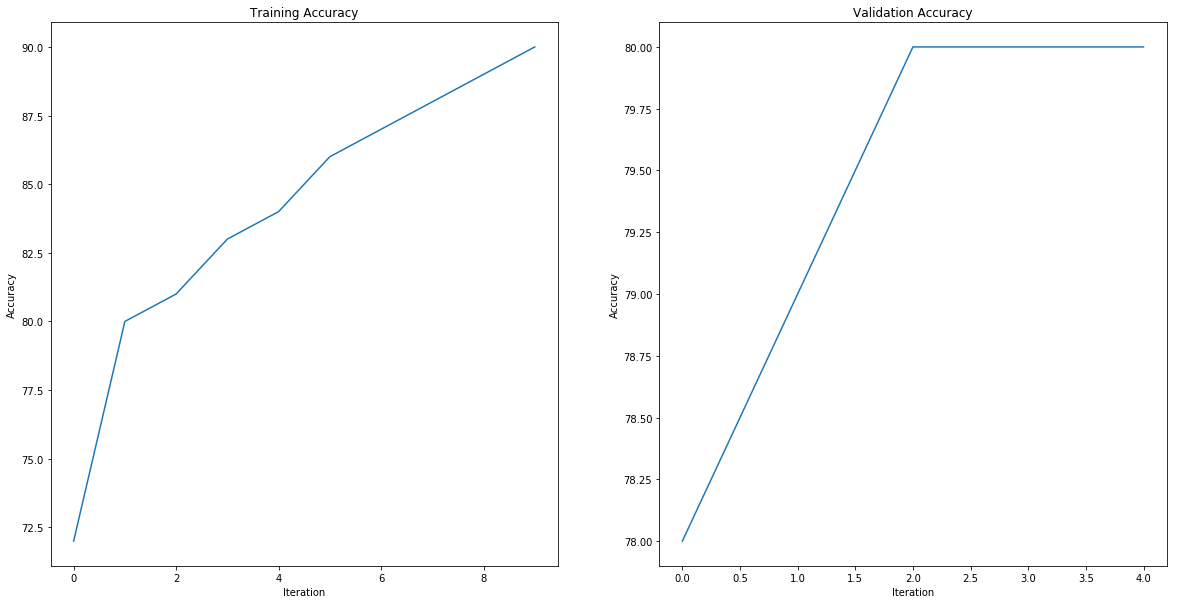

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(121)
plt.title('Training Accuracy')
plt.plot(train_acc_ls)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

plt.subplot(122)
plt.title('Validation Accuracy')
plt.plot(val_acc_ls)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')